🚀 Starting Time Series Analysis with PyTorch
✅ Generated time series with 1000 points
✅ Data split - Train: 800, Test: 200
✅ Created datasets with sequence length: 50
✅ Model initialized with 50497 parameters

🔄 Starting model training...
Epoch [10/50], Loss: 0.005333
Epoch [20/50], Loss: 0.004931
Epoch [30/50], Loss: 0.004955
Epoch [40/50], Loss: 0.004674
Epoch [50/50], Loss: 0.004891
✅ Training completed!
✅ Generated 50 future predictions

📊 Model Performance Metrics:
Mean Absolute Error (MAE): 0.0529
Root Mean Square Error (RMSE): 0.0668


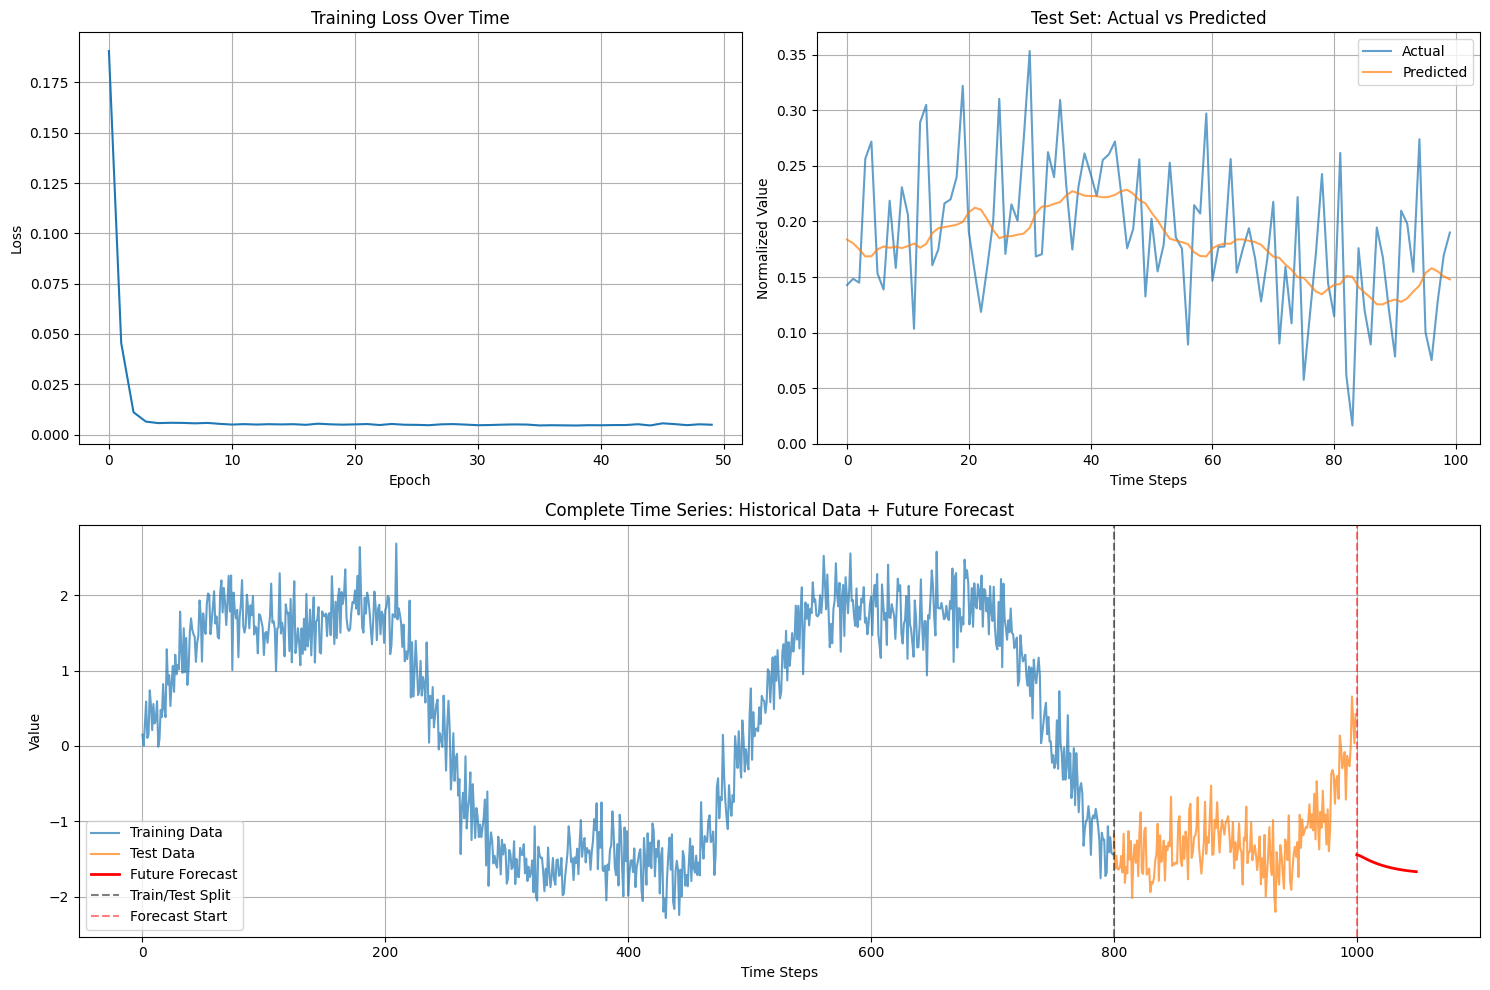


🎯 Exercise Summary:
• Generated synthetic time series with 1000 points
• Used LSTM with 50 time steps lookback window
• Trained for 50 epochs with batch size 32
• Achieved MAE: 0.0529, RMSE: 0.0668
• Forecasted 50 future time steps
• Model has 50497 trainable parameters

🔍 Key Concepts Demonstrated:
✓ Synthetic time series generation with trend + seasonality
✓ Data normalization and sliding window preprocessing
✓ LSTM architecture for sequence modeling
✓ Training loop with backpropagation
✓ Multi-step ahead forecasting
✓ Model evaluation with MAE and RMSE
✓ Comprehensive visualization of results

🚀 Exercise completed successfully!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("🚀 Starting Time Series Analysis with PyTorch")
print("=" * 50)

### Step 1: Generate Synthetic Time Series Data
def generate_time_series(n_points=1000):
    """Generate synthetic time series with trend, seasonality, and noise"""
    t = np.linspace(0, 4*np.pi, n_points)
    
    # Components of the time series
    trend = 0.02 * t  # Linear trend
    seasonal = 2 * np.sin(t) + 0.5 * np.sin(3*t)  # Multiple seasonal patterns
    noise = np.random.normal(0, 0.3, n_points)  # Random noise
    
    # Combine all components
    series = trend + seasonal + noise
    return series, t

### Generate the time series
data, time_points = generate_time_series(1000)
print(f"✅ Generated time series with {len(data)} points")

### Step 2: Data Preprocessing
class TimeSeriesDataset(Dataset):
    """Custom Dataset for time series sliding windows"""
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.sequence_length]
        y = self.data[idx + self.sequence_length]
        return torch.FloatTensor(x), torch.FloatTensor([y])

### Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).flatten()

### Split data into train and test sets
train_size = int(0.8 * len(data_normalized))
train_data = data_normalized[:train_size]
test_data = data_normalized[train_size:]

print(f"✅ Data split - Train: {len(train_data)}, Test: {len(test_data)}")

### Create datasets and dataloaders
sequence_length = 50  # Look back window
batch_size = 32

train_dataset = TimeSeriesDataset(train_data, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TimeSeriesDataset(test_data, sequence_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ Created datasets with sequence length: {sequence_length}")

### Step 3: Define LSTM Model
class LSTMForecaster(nn.Module):
    """LSTM model for time series forecasting"""
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMForecaster, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=0.2)
        
        # Output layer
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x.unsqueeze(-1), (h0, c0))
        
        # Get the last output and pass through linear layer
        output = self.linear(lstm_out[:, -1, :])
        return output

### Initialize model, loss function, and optimizer
model = LSTMForecaster(input_size=1, hidden_size=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"✅ Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

### Step 4: Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    """Train the LSTM model"""
    model.train()
    train_losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
    
    return train_losses

print("\n🔄 Starting model training...")
train_losses = train_model(model, train_loader, criterion, optimizer, epochs=50)
print("✅ Training completed!")

### Step 5: Model Evaluation and Forecasting
def forecast_future(model, last_sequence, n_future=50):
    """Forecast future values using the trained model"""
    model.eval()
    forecasts = []
    current_sequence = last_sequence.copy()
    
    with torch.no_grad():
        for _ in range(n_future):
            # Prepare input
            input_tensor = torch.FloatTensor(current_sequence).unsqueeze(0)
            
            # Make prediction
            prediction = model(input_tensor).item()
            forecasts.append(prediction)
            
            # Update sequence (sliding window)
            current_sequence = np.append(current_sequence[1:], prediction)
    
    return np.array(forecasts)

### Get the last sequence from training data for forecasting
last_sequence = train_data[-sequence_length:]
future_predictions = forecast_future(model, last_sequence, n_future=50)

print(f"✅ Generated {len(future_predictions)} future predictions")

### Step 6: Evaluate on Test Set
def evaluate_model(model, test_loader):
    """Evaluate model performance on test set"""
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            pred = model(batch_x)
            predictions.extend(pred.numpy().flatten())
            actuals.extend(batch_y.numpy().flatten())
    
    return np.array(predictions), np.array(actuals)

test_predictions, test_actuals = evaluate_model(model, test_loader)

### Calculate metrics
mae = mean_absolute_error(test_actuals, test_predictions)
rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))

print(f"\n📊 Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

### Step 7: Visualization
plt.figure(figsize=(15, 10))

### Plot 1: Training Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

### Plot 2: Test Set Predictions
plt.subplot(2, 2, 2)
plt.plot(test_actuals[:100], label='Actual', alpha=0.7)
plt.plot(test_predictions[:100], label='Predicted', alpha=0.7)
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)

### Plot 3: Full Time Series with Forecast
plt.subplot(2, 1, 2)

### Denormalize data for better visualization
train_denorm = scaler.inverse_transform(train_data.reshape(-1, 1)).flatten()
test_denorm = scaler.inverse_transform(test_data.reshape(-1, 1)).flatten()
future_denorm = scaler.inverse_transform(future_predictions.reshape(-1, 1)).flatten()

### Plot historical data
plt.plot(range(len(train_denorm)), train_denorm, label='Training Data', alpha=0.7)
plt.plot(range(len(train_denorm), len(train_denorm) + len(test_denorm)), 
         test_denorm, label='Test Data', alpha=0.7)

### Plot future predictions
future_start = len(train_denorm) + len(test_denorm)
plt.plot(range(future_start, future_start + len(future_denorm)), 
         future_denorm, label='Future Forecast', color='red', linewidth=2)

plt.axvline(x=len(train_denorm), color='black', linestyle='--', alpha=0.5, label='Train/Test Split')
plt.axvline(x=future_start, color='red', linestyle='--', alpha=0.5, label='Forecast Start')

plt.title('Complete Time Series: Historical Data + Future Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Step 8: Summary
print(f"\n🎯 Exercise Summary:")
print(f"{'='*50}")
print(f"• Generated synthetic time series with {len(data)} points")
print(f"• Used LSTM with {sequence_length} time steps lookback window")
print(f"• Trained for 50 epochs with batch size {batch_size}")
print(f"• Achieved MAE: {mae:.4f}, RMSE: {rmse:.4f}")
print(f"• Forecasted {len(future_predictions)} future time steps")
print(f"• Model has {sum(p.numel() for p in model.parameters())} trainable parameters")

print(f"\n🔍 Key Concepts Demonstrated:")
print(f"✓ Synthetic time series generation with trend + seasonality")
print(f"✓ Data normalization and sliding window preprocessing")
print(f"✓ LSTM architecture for sequence modeling")
print(f"✓ Training loop with backpropagation")
print(f"✓ Multi-step ahead forecasting")
print(f"✓ Model evaluation with MAE and RMSE")
print(f"✓ Comprehensive visualization of results")

print(f"\n🚀 Exercise completed successfully!")